# READ BEFORE RUNNING THE NOTEBOOK

### Run the following command in the shell before running the notebook
```conda env create -f environment.yml -n Project_Barklow && conda activate Project_Barklow```

In [3]:
import zipfile
with zipfile.ZipFile("pb_data.zip","r") as zip_ref:
    zip_ref.extractall(".")

* Some functions get defined in multiple places just to make reading the code easier.

In [4]:
import pandas,numpy,os,random,csv,ast
from pyspark import SparkContext
from pyspark.mllib.clustering import KMeans
from matplotlib import pyplot as plt

sc = SparkContext.getOrCreate()
def processCsvDirectory(path):
    
    timeData = {}
    with os.scandir(path) as files:
        for x,file in enumerate(files):
            if file.name.endswith('.csv') and file.is_file():
                gameDF = pandas.read_csv(path + file.name,dtype={'Time':str,'Playercount':float})
                gameDF = gameDF.fillna(0)
                
                appID = file.name.split('.csv')[0]
                
                timeData[appID] = getActualData(gameDF)       
    return timeData

def getActualData(frame):
    # removing the time stamps from each date, since the lowest interval of data I want to look at is daily
    times = [x.split(' ')[0] for x in list(frame['Time'])]
    players = list(frame['Playercount'])
    

    # creating a spark RDD from the list of dates and the list of players counts
    datePlayer = list(zip(times, players))
    coolRDD = sc.parallelize(datePlayer)

    # max daily player
    maxDailyPlayers = coolRDD.reduceByKey(max)
     
    # reduce to just year with daily peak counts
    yearRDD = maxDailyPlayers.map(lambda x: (x[0].split('-')[0], x[1]))
 
    # group into lists
    yearListRDD = yearRDD.groupByKey().mapValues(list)
    yearlyPeakAVG = yearListRDD.map(lambda x: ( x[0] , sum(x[1])/len(x[1]) ))

    return sorted(yearlyPeakAVG.collect(), key=lambda x: x[0])

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/05 02:43:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Step 1 - Reading in Data

### To get the data, I use multiple functions. In the cells below, I show the functions in the general order they process the data in with an explanation of what each one does.

The first function I use is ```getYearlyData``` which takes a string, either 'from processed' or 'from scratch' which determines whether to completely re-read in the base data and process it again, or use saved data that has already been processesd to save time.

```getYearlyData```, if called with 'from processed', just reads in the processed data from a csv file. If it is called with 'from scratch', then it calls another function, ```processCsvDirectory``` with a filepath of a directory containing csv files. In this directory, each csv file represents player count data for a single application. After calling the other functions to get usable data, it calculates the average growth for a game's player count in the years leading up to COVID-19 versus its growth from the year before to the year of the start of signifcant COVID-19 global lockdowns.

In [5]:
def getYearlyData(method):
    timeData = {}
    growthList = []

    if(method == 'from scratch'):
        
        timeData = processCsvDirectory('./history/PlayerCountHistoryPart1/')
        
    elif(method == 'from processed'):
        with open('./history/Top1000_YearlyAVG.csv', 'r') as f:
            reader = csv.reader(f, delimiter = ',')
    
            keys = next(reader)
            values = next(reader)
            newValues = [ast.literal_eval(x) for x in values]
            timeData = dict(zip(keys,newValues))

           
    for k,v in timeData.items():
                growthList.append([k,growthRate(v),-1])
            
    return timeData,growthList

def getGrowth(first, last):
    if first == 0:
        first = 1
        
    x = last/first
    
    y = x**(1/4)
    
    z = round(((y-1)*100),2)
    
    return z

def growthRate(years):

    preCovidGrowth = getGrowth(years[0][1], years[2][1])
    
    covidGrowth = getGrowth(years[2][1], years[3][1])

    return [covidGrowth,preCovidGrowth]   

In [6]:
timeData,growthList = getYearlyData('from scratch')

```processCsvDirectory``` takes a directory of csv files, and if found to be a valid file, turns it into a pandas dataframe. Each of these dataframes is passed into another function, ```getActualData```, which is defined below. The results from this function are stored in a dictionary keyed on the ID of the application being processed.

In [7]:
def processCsvDirectory(path):
    
    timeData = {}
    with os.scandir(path) as files:
        for x,file in enumerate(files):
            print(file.name,x)
            if file.name.endswith('.csv') and file.is_file():
                gameDF = pandas.read_csv(path + file.name,dtype={'Time':str,'Playercount':float})
                gameDF = gameDF.fillna(0)
                
                appID = file.name.split('.csv')[0]
                
                timeData[appID] = getActualData(gameDF)
                
    return timeData

The reason that ```getActualData``` to exist is due to the format of the csv files. Each csv file contains the playercount of an application every 15 minutes for 4 years. This means that each file tends to contain hundreds of thousands of lines. To process all of this in a reasonable amount, I make use of Map and Reduce with Spark. I turn each line of data into only its year as the identifier, and then reduce the keys into first the peak player count of an application for each day, then a list of peak player counts for each year, and finally an average peak daily player count for each year.

In [8]:
def getActualData(frame):
    
    # removing the time stamps from each date, since the lowest interval of data I want to look at is daily
    times = [x.split(' ')[0] for x in list(frame['Time'])]
    players = list(frame['Playercount'])
    
    # creating a spark RDD from the list of dates and the list of players counts
    datePlayer = list(zip(times, players))
    coolRDD = sc.parallelize(datePlayer)
    
    # max daily player
    maxDailyPlayers = coolRDD.reduceByKey(max)
 
    # reduce to just year with daily peak counts
    yearRDD = maxDailyPlayers.map(lambda x: (x[0].split('-')[0], x[1]))

    # group into lists
    yearListRDD = yearRDD.groupByKey().mapValues(list)
    yearlyPeakAVG = yearListRDD.map(lambda x: ( x[0] , sum(x[1])/len(x[1]) ))

    return sorted(yearlyPeakAVG.collect(), key=lambda x: x[0])

Here, I read in other useful CSV files, like one that maps the name of an application to its ID, and the one used to store the genre tags of each application.

In [9]:
appInfo = pandas.read_csv("./csv/applicationInformation.csv", encoding_errors="ignore")
cols = [str(x) for x in range(0,60)]
appGenres = pandas.read_csv("./csv/applicationTags.csv",names=cols,encoding_errors="ignore",header=None)
appGenres.fillna('',inplace=True)
genreDict = appGenres.set_index('0').T.to_dict('list')
filterg = pandas.read_csv("./csv/applicationGenres.csv",names=cols,encoding_errors="ignore",header=None)

ids = list(appInfo['appid'])
names = list(appInfo['name'])
idName = dict(zip(ids,names))

# Step 2 - Clustering

### Although it is easy to get the conclusion that the general player count of games went up during COVID-19, I wanted to do a deeper analysis, specifically on which games were affected in what ways. To do this, I use Spark and Kmeans to cluster all of the 1000 games by the average growths of pre versus post covid population numbers.

Below, I calculate what the optimal value of K would be using the elbow method.

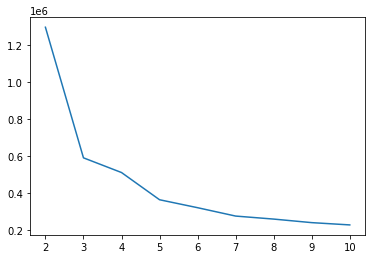

In [10]:
growthRDD = sc.parallelize([x[1] for x in growthList])  
computeList = []
K = [*range(2,11)]

for x in K:
    model = KMeans.train(growthRDD, x, maxIterations=10, initializationMode='random')
    computeList.append(model.computeCost(growthRDD))

plt.plot(K, computeList)
        

Below, I define and run a function that clusters the data, and returns the cluster ids of each data point. It then creates a data structure to map the cluster id to each application.

In [11]:
def clusterData(data, K):
    model = KMeans.train(data, K, maxIterations=10, initializationMode='random')
    cluster_ids = model.predict(data)
    return data,cluster_ids.collect()
    
K = 6

data,clusterids = clusterData(growthRDD,K)

for i,x in enumerate(growthList):
    growthList[i][2] = (clusterids[i])


The below cell performs a few different operations using the data. First, it creates another list to group all of the different clusters into separate lists. Then, it calculates how many of each application in each cluster is tagged with a certain genre. These counts are kept track of in dictionaries. Finally, it calculates what percentage of each cluster is tagged with each genre tag. I opted to not use Spark here since the operations weren't very computationally intensive compared to what I had to do earlier.

In [12]:
clusterList = [[] for x in range(0,K)]
diffList = [[] for x in range(0,K)]
genreList = [{} for x in range(0,K)]
diffDict = [[] for x in range(0,K)]


for x in growthList:
    clusterList[x[2]].append(int(x[0]))
    
for x in growthList:
    diffList[x[2]].append((int(x[0]),x[1]))
                          

genreLens = [len(x) for x in clusterList]

# get genres for each cluster and data entry
for i,x in enumerate(clusterList):
    for y in x:
        idGenres = genreDict[y]
        if 'Multiplayer' in idGenres and 'Singleplayer' in idGenres:
            idGenres.remove('Singleplayer')
        for z in idGenres:
            if z != '':
                if z in genreList[i]:
                    genreList[i][z] += 1
                else:
                    genreList[i][z] = 1  


for i,x in enumerate(genreList):
    z = sorted(list(x.items()),key = lambda x: x[1],reverse=True)
    genreList[i] = z

for i,x in enumerate(genreList):
    for j,y in enumerate(x):
        genreList[i][j] = (y[0],round((y[1]/genreLens[i]) * 100,2))

# calculate average/ percentage        
for i,x in enumerate(diffList):
    differentialTotal = 0
    for y in x:
        differential = y[1][0] - y[1][1]
        differentialTotal += differential
        
    differentialAvg = differentialTotal/len(x)
    
    diffDict[i] = differentialAvg

 # Step 3 - Visualization

### To visualize the data I obtained, I use a few different graphing methods with Matplotlib and pyplot.

```plotBasicClusters``` takes the data, the cluster ids, and simply maps the clusters in a scatter plot.

In [13]:
def plotBasicClusters(data, cluster_ids):
    data = numpy.array(data.collect())
    ax = plt.axes()
    ax.set_facecolor('white')
    plt.rcParams['figure.facecolor'] = 'white'
    plt.scatter(data[:,0], data[:,1], c=cluster_ids, s=1,cmap='tab10')
 
    plt.xlabel('2019-2020 Change')
    plt.ylabel('2017-2019 Change')
    plt.title('4 Year Increase vs Covid Increase')
    plt.colorbar()
    plt.axhline(0, color='black',lw=.5)
    plt.axvline(0, color='black',lw=.5)
    plt.show()
    plt.clf()
   

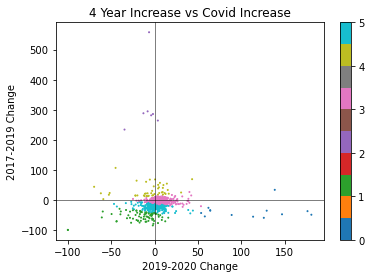

<Figure size 432x288 with 0 Axes>

In [14]:
plotBasicClusters(data,clusterids)

```plotCovidChange``` creates a bar chart that represents the differential between the games population growth before and after the onset of COVID.

In [15]:
def plotCovidChange(data):

    df = pandas.DataFrame([data],columns = [x for x in range(0,K)] )
    df=df.T
    df[0].plot(kind='bar')
    plt.title("Game Cluster Covid Population Differential")
    plt.ylabel("Average Covid Pop. Change")
    plt.xlabel("Cluster")
    plt.axhline(0, color='black',lw=.3)

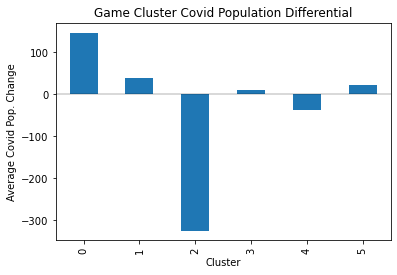

In [16]:
plotCovidChange(diffDict)

```plotGenrePercentages``` is used to generate charts representing what percentage of the games were tagged with different genres. I created it in a way that I can easily add a filter of what genres I wanted to display by just adding onto an elif chain that defines a different criteria to generate the plot for. I call this function with the genre comparisons I wanted to see below.

In [17]:
def plotGenrePercentages(data,graphType):
    bigList = []
    criteria = []
    critDict = {}
    titleP = ""
            
    for i,x in enumerate(data):      
        if(graphType == 'singleMulti'):
            criteria = ['Singleplayer','Multiplayer']
            titleP = "Singleplayer v. Multiplayer"
        elif(graphType == 'genre'):
            criteria = ['RPG','Shooter','Sports','Simulation','Strategy']
            titleP = "Defining Genre"
        elif(graphType == 'difficult'):
            titleP = "Difficulty"
            criteria = ['Difficult','Casual']
            
        critDict = {x:-1 for x in criteria}
    
        for y in x:
            if y[0] in critDict:
                critDict[y[0]] = y[1]
        coolList = list(critDict.values())
        coolList.insert(0,i)

        bigList.append(coolList)

    criteria.insert(0,'Cluster')
    plotDf = pandas.DataFrame(bigList,columns=criteria)

    plotDf.plot(x='Cluster',kind='bar',stacked=True,title=titleP)
    

It should be noted that the reason that the percentage of genres adds up to more than 100% is because almost every game will be tagged with multiple genres.

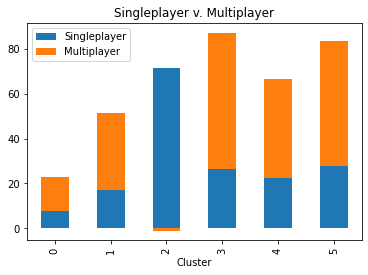

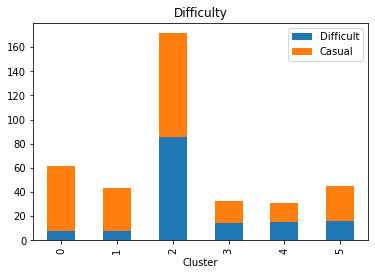

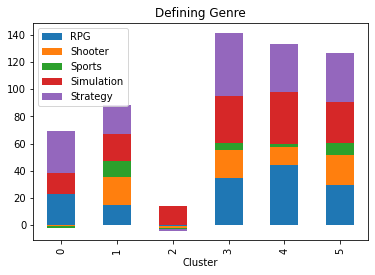

In [18]:
plotGenrePercentages(genreList,'singleMulti')
plotGenrePercentages(genreList,'difficult')
plotGenrePercentages(genreList,'genre')

The charts and visualizations produced as the end product of this notebook will form the basis for the poster of the project.